In [1]:
%pylab inline

/home/riri/.virtualenvs/bayesdb2/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import bayeslite                 # The database imports
import bayeslite.read_pandas     # This pulls in datasets from pandas
import pandas                    # Pandas!
import seaborn as sns            # Seaborn does really neat python statistical graphs
import bdbcontrib.bql_utils      # Tools for interacting with BDB
from tqdm import tqdm            # A progress bar.
from sklearn import ensemble     # We'll test against the SKlearn classifiers!
from sklearn import linear_model # 

# Setup
Here we load up the dataset. Set the name and email address as appropriate - this is so MIT knows who to contact when they see your genius queries :).

The database itself has three tables, and three generators.

* `votes` and `votes_cc` are the table and generator holding both voting and demographc data
* `demographics` and `demographics_cc` are the table and generator with demographic data alone
* `votes_heldout` and `votes_heldout_cc` have all the demographic data, as well as a single column for whether the ALP won. _Half_ of the ALP won values have been replaced with `null`.
* The ALP won column is true when the votes for the ALP and CLP exeed those of the Liberals, Nationals and Liberal Nationals.

We also open the database as a raw connection (bdb) and also wrapped in the Population helper, which gives us some easier ways to access the data.

In [3]:
session_capture_name = 'Richard Weiss richardweiss@richardweiss.org'
assert session_capture_name != 'Your Name yourname@example.com'

bdb = bayeslite.bayesdb_open('./data.bdb')

votes = bdbcontrib.Population(
    'votes', 
    bdb_path='./data.bdb', 
    session_capture_name=session_capture_name)

BQL [SELECT * FROM bayesdb_generator] ()

# Exploring a table

It's useful to know what's in a table. To investigate the types of the different columns, you can use the `variable_stattypes` recipe in bdbcontrip. 

It's important to review these types - sometimes the autodetection of the column types doesn't quite work.

In [4]:
bdbcontrib.bql_utils.variable_stattypes(bdb, 'votes_heldout_cc')

,colno,name,stattype
0,1.0,area_size,numerical
1,2.0,population,numerical
2,3.0,sex_ratio,numerical
3,4.0,mean_children,numerical
4,5.0,participation_rate,numerical
5,6.0,unemployment_rate,numerical
6,7.0,median_age,numerical
7,8.0,median_weekly_income,numerical
8,9.0,ALP_win,categorical


# Searching for relationships
Here, we look for _mutual information_ between the columns of the votes generator. This helps us identify which columns are related.

BQL [ESTIMATE MUTUAL INFORMATION FROM PAIRWISE COLUMNS OF votes_cc] ()

Detected value limits as [0, 1]. Override with vmin and vmax.


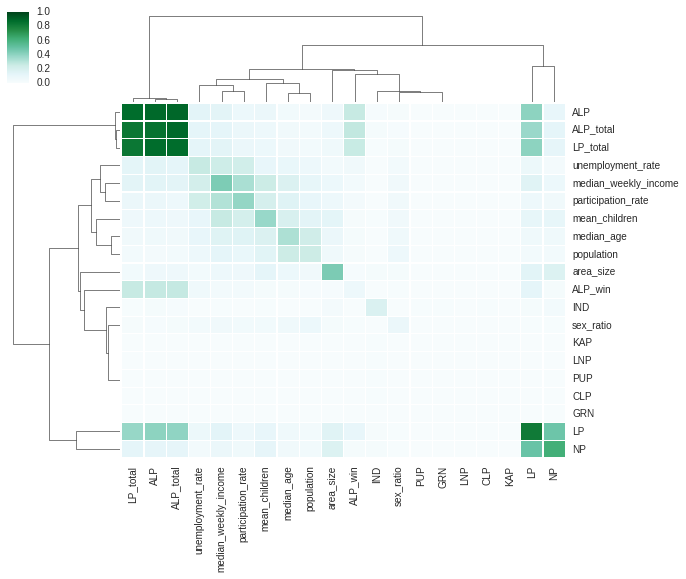

In [6]:
votes.heatmap(votes.q('ESTIMATE MUTUAL INFORMATION FROM PAIRWISE COLUMNS OF votes_cc'))

## Inspecting models

Instead of computing mutual information, we can inpsect the underyling _CrossCat_ model. This gives a better indication of the underlying relationships in the data.

BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF votes_cc] ()

Detected value limits as [0, 1]. Override with vmin and vmax.


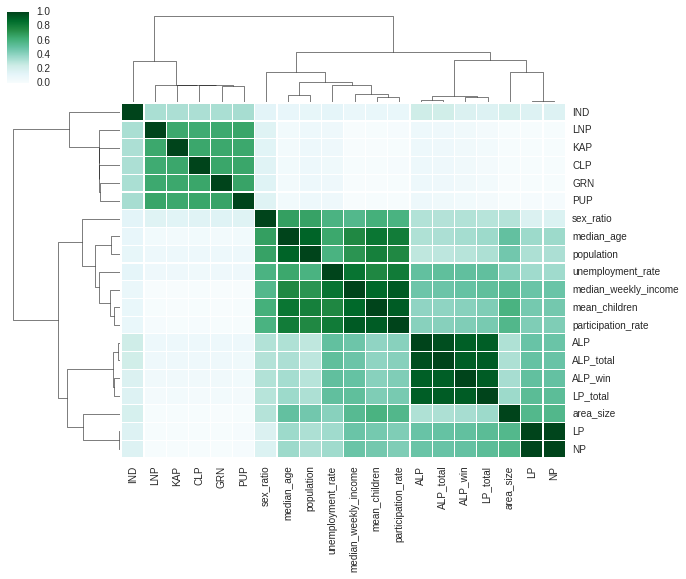

In [7]:
votes.heatmap(votes.q('ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF votes_cc'))

## What can we see?

In both cases:
* Voting columns tend to be mutually informative.
* The Liberal party and National party are highly informative of each other. This is because the Liberals don't appear on the ballots in National Party seats, so if you know one of them got votes, the other did not.
* The ALP and Liberal party counts are closely related - again, because it's two party preferred.
* The demographic factors interrelate to each other
* The independent parties tend to do their own thing, but this is because we have so little data on them.

Also, remember that _CrossCat_ builds "views" containing subsets of the columns. You can see this expressed in the dependence probability heatmap. The independent parties seem to have formed their own group, perhaps because they have similar behaviour (rarely appearing in the two-party preferred vote), and also because it's so unlikely that a seat will vote for _two_ smaller parties. This means that they form a neat cluster on their own - because if one of the independent parties appears, then none of the others will.

# Clustering data

Now that we've got an idea of how the _columns_ relate to each other, it's useful to take a look at how the data clusters together.

While we could cluster the vote data, it's quite a boring thing to do. We simply see that there are Liberal voting seats, and Labour voting seats.

A more interesting thing to do is to cluster the _demographic_ data, and see if voting patterns "fall out".

BQL [select area_name, ALP_win from votes] ()

BQL [ESTIMATE SIMILARITY FROM PAIRWISE demographics_cc] ()

Detected value limits as [0, 1]. Override with vmin and vmax.


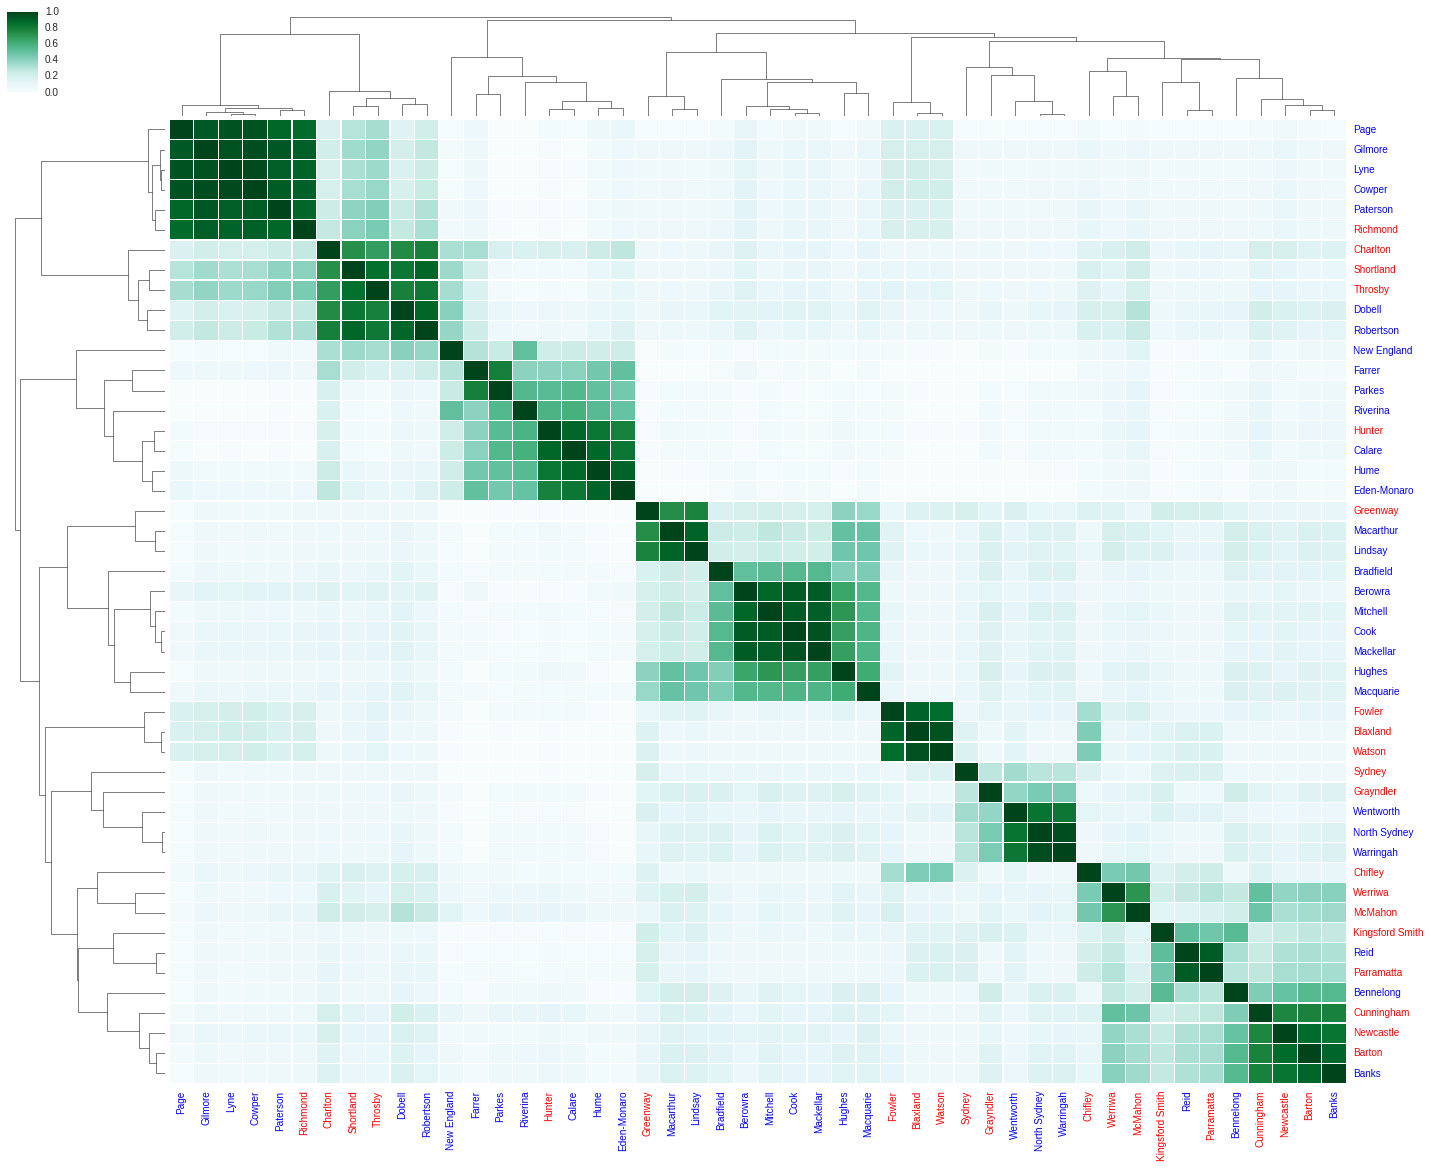

In [8]:
rows = votes.q('select area_name, ALP_win from votes')
pair_sim = votes.q('ESTIMATE SIMILARITY FROM PAIRWISE demographics_cc')
rownames = rows.area_name
alp_won = set(rows[rows.ALP_win == 1].area_name)
figure(figsize=(20,20))
a = votes.heatmap(pair_sim, xticklabels=rownames, yticklabels=rownames)
for vv in a.ax_heatmap.get_xticklabels():
    if vv.get_text() in alp_won:
        vv.set_color('red')
    else:
        vv.set_color('blue')
for vv in a.ax_heatmap.get_yticklabels():
    if vv.get_text() in alp_won:
        vv.set_color('red')
    else:
        vv.set_color('blue')

## What do we see?

Excitingly, we do see some clustering of votes into the same groups! Showing the importance of these demographic factors in determining voting patterns.

# Simulation

BayesDB lets us simulate data quite easily. This is often a particularly challenging task, and one that's easy to get wrong, so having such a simple way to do it can help a lot, especially in initial exploration of data.

In [9]:
a = votes.q('''
    SIMULATE ALP, LP, NP 
    FROM votes_cc given 
    median_age = 35
    LIMIT 10000''')

b = votes.q('''
    SIMULATE ALP, LP, NP 
    FROM votes_cc given 
    median_age = 40
    LIMIT 10000''')
print(a.mean())
print(b.mean())

BQL [
 SIMULATE ALP, LP, NP 
 FROM votes_cc given 
 median_age = 35
 LIMIT 10000] ()

BQL [
 SIMULATE ALP, LP, NP 
 FROM votes_cc given 
 median_age = 40
 LIMIT 10000] ()

ALP    0.463010
LP     0.432984
NP     0.097946
dtype: float64
ALP    0.444573
LP     0.406132
NP     0.130269
dtype: float64


## Graphical presentation

As part of the simulation, we drew 10,000 samples from each generator. Now, the average is interesting, but why stop there? We get a far better picture by graphically presenting the histogram of the data:

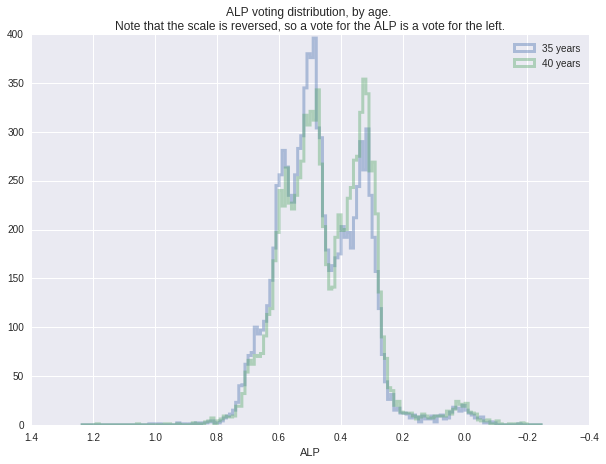

In [10]:
figure(figsize=(10,7))
sns.distplot(a.ALP, bins=numpy.arange(-0.25, 1.25, 0.01), kde=False, label='35 years', 
             hist_kws={"histtype": "step", 'linewidth': 3})
sns.distplot(b.ALP, bins=numpy.arange(-0.25, 1.25, 0.01), kde=False, label='40 years',
             hist_kws={"histtype": "step", 'linewidth': 3})
legend()
plt.gca().invert_xaxis()

title('ALP voting distribution, by age. \n'
      'Note that the scale is reversed, so a vote for the ALP is a vote for the left.')

## And just to make sure...

BQL [SELECT ALP_win, median_age FROM votes] ()

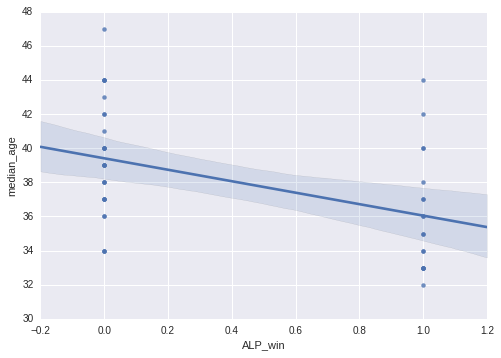

In [11]:
data = votes.q('SELECT ALP_win, median_age FROM votes')
sns.regplot('ALP_win', 'median_age', data)

## Modeling accuracy

This also shows an issue in _CrossCat_. You can see that the ALP's two party preferred vote, as a proportion, actually goes into **negative** votes. Not traditionally possible! 

The reason for this is that _CrossCat_ models numerical data, such as this, with a normal distribution. And of course, a normal distribution extends all the way from positive to negative infinity.

# Classification

Clustering is all well and good, but another very interesting question is whether it's possible to predict a seat's outcome, given its demographics. For this, we use the ``votes_heldout_cc`` generator, which keeps only the ``ALP_win`` column, and all the demographic data:

In [12]:
bdbcontrib.bql_utils.variable_stattypes(bdb, 'votes_heldout_cc')

,colno,name,stattype
0,1.0,area_size,numerical
1,2.0,population,numerical
2,3.0,sex_ratio,numerical
3,4.0,mean_children,numerical
4,5.0,participation_rate,numerical
5,6.0,unemployment_rate,numerical
6,7.0,median_age,numerical
7,8.0,median_weekly_income,numerical
8,9.0,ALP_win,categorical


To get better results, I've done multiple classification rounds

In [13]:
votes_heldout = votes.q('select * FROM votes_heldout')
votes_true = votes.q('select ALP_win FROM votes').as_matrix()[:, 0]
votes_is_test = votes.q('select ALP_win is null as is_test FROM votes_heldout').is_test
votes_is_train = votes.q('select ALP_win is not null as is_train FROM votes_heldout').is_train

BQL [select * FROM votes_heldout] ()

BQL [select ALP_win FROM votes] ()

BQL [select ALP_win is null as is_test FROM votes_heldout] ()

BQL [select ALP_win is not null as is_train FROM votes_heldout] ()

In [14]:
# You'll want to run this several times, for better accuracy.
pred = votes.q('INFER ALP_win FROM votes_heldout_cc').as_matrix()[:, 0]
sameness = (pred == votes_true)[np.nonzero(votes_is_test)]

BQL [INFER ALP_win FROM votes_heldout_cc] ()

In [15]:
print('BayesDB manages: %f' % mean(sameness))

BayesDB manages: 0.736842


In [16]:
classifier_data = votes_heldout.drop(['area_name'], axis=1)
X_train = classifier_data[votes_is_train == 1].drop('ALP_win', axis=1)
y_train = votes_true[np.nonzero(votes_is_train == 1)]

X_test = classifier_data[votes_is_test == 1].drop('ALP_win', axis=1)
y_test = votes_true[np.nonzero(votes_is_test == 1)]

In [17]:
cls = ensemble.ExtraTreesClassifier(n_estimators=1000)
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
(y_pred == y_test).mean()
print('The Extra Trees classifier manages: ' + str((y_pred == y_test).mean()))

The Extra Trees classifier manages: 0.894736842105


In [18]:
cls = linear_model.LogisticRegression()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
(y_pred == y_test).mean()
print('The logistic regression classifier manages: ' + str((y_pred == y_test).mean()))

The logistic regression classifier manages: 0.789473684211
